In [1]:
import pandas as pd
from constants import x_path, y_path

X = pd.read_csv(x_path)
y = pd.read_csv(y_path)

print(X.shape)

(21613, 18)


In [10]:
from sklearn import decomposition
import matplotlib.pyplot as plt
import umap

# reducer = decomposition.PCA(n_components='mle')
reducer = umap.UMAP(n_components=15, n_epochs=400, learning_rate=0.005)
# print('> Reducer:', reducer)
reducer_model = reducer.fit(X)
X_reduced = reducer_model.transform(X)
# X_reduced = reducer_model.embedding_
print('- X reduced shape: ', X_reduced.shape)
# plt.scatter(reducer_model.embedding_[:, 0], reducer_model.embedding_[:, 1], s=5, c=y, cmap='Spectral')
# plt.title('Embedding of the training set by reducer', fontsize=24)


- X reduced shape:  (21613, 15)


In [11]:
from libs.simple_processing import separate_target, split_train_test

X_train, X_valid, y_train, y_valid = split_train_test(X_reduced, y, 0.7)

print("Done")

Done


In [17]:
from tensorflow import keras
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from libs.dl.simple_regressor import build_compile

early_stopping = EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=7,  # how many epochs to wait before stopping
    restore_best_weights=True
)



def build_regressor(hp):
    min = 130
    max = 160
    step = 4
    feat_count = X_train.shape[1]

    m = Sequential()
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu", input_shape=[feat_count]))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(units=hp.Int("units", min_value=min, max_value=max, step=step), activation="relu"))
    m.add(Dense(1))

    m.compile(
        optimizer="adam",
        loss="mean_absolute_error",
        metrics=[keras.metrics.MeanAbsoluteError()],
    )
    return m


# tuner = keras_tuner.RandomSearch(
tuner = keras_tuner.Hyperband(
    hypermodel=build_regressor,
    # The objective name and direction.
    # Name is the f"val_{snake_case_metric_class_name}".
    objective=keras_tuner.Objective("val_mean_absolute_error", direction="min"),
    max_epochs=50,
    factor=3,
    seed=42,
    # max_trials=2,
    overwrite=True,
    directory="keras_tuner"
)

tuner.search(
    x=X_train,
    y=y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_valid, y_valid)
)

tuner.results_summary()
# tuner.search_space_summary()
winner = tuner.get_best_models(num_models=1)
# print(winner)
winner = winner[0]
# best_model = models
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
winner.build(input_shape=[X_train.shape[1]])
winner.summary()
score = winner.evaluate(X_valid, y_valid, verbose=0)
print("Test Loss: ", score)

Trial 8 Complete [00h 00m 04s]
val_mean_absolute_error: 211385.3125

Best val_mean_absolute_error So Far: 208853.265625
Total elapsed time: 00h 00m 34s
INFO:tensorflow:Oracle triggered exit
Results summary
Results in keras_tuner/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 150
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 208853.265625
Trial summary
Hyperparameters:
units: 158
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 209078.71875
Trial summary
Hyperparameters:
units: 142
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 210482.90625
Trial summary
Hyperparameters:
units: 134
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 210969.65625
Trial summary
Hyperparameters:
units: 138
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 211384.859375
Trial summary
Hyperparameters:
units: 154
tuner/epochs: 2
tuner/

2022-12-07 10:49:45.090000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test Loss:  [208853.28125, 208853.28125]


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

features_count = X_train.shape[1]
units = 150
activation = 'relu'

model = Sequential()
# model.add(Dense(18, activation=relu, input_shape=[features_count]))
model.add(Dense(units, activation=activation, input_shape=[features_count]))
model.add(Dense(units, activation=activation))
model.add(Dense(units, activation=activation))
model.add(Dense(units, activation=activation))
model.add(Dense(units, activation=activation))
model.add(Dense(units, activation=activation))
# model.add(Dense(54, activation='relu'))
# model.add(Dense(54, activation='relu'))
# model.add(Dense(features_count, activation='relu'))
# model.add(Dense(features_count, activation='relu'))
model.add(Dense(1))

model.compile(
    optimizer='adam'
    # ,loss='mes'
    # , loss='mae'
    # , loss='mean_squared_error'
    , loss='mean_absolute_error'
    , metrics=[keras.metrics.MeanAbsoluteError()]
    # , metrics=[keras.metrics.MeanAbsoluteError()]
)

history = model.fit(x=X_train, y=y_train,
                    validation_data=(X_valid,y_valid)
                    , batch_size=128
                    , epochs=400
                    # , callbacks=[early_stopping]
                    , use_multiprocessing=True
                    # , verbose='2'
                    )

history_df = pd.DataFrame(history.history)
print("Minimum Validation Loss: {:0.5f}".format(history_df['val_loss'].min()))
print(history_df)

Epoch 1/400


2022-12-07 10:50:22.664513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - ETA: 0s - loss: 364511.6875 - mean_absolute_error: 364511.6875

2022-12-07 10:50:24.813703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 3s 16ms/step - loss: 364511.6875 - mean_absolute_error: 364511.6875 - val_loss: 213149.3281 - val_mean_absolute_error: 213149.3281
Epoch 2/400
119/119 [==============================] - 1s 10ms/step - loss: 221602.0156 - mean_absolute_error: 221602.0156 - val_loss: 211694.5625 - val_mean_absolute_error: 211694.5625
Epoch 3/400
119/119 [==============================] - 1s 10ms/step - loss: 217836.9219 - mean_absolute_error: 217836.9219 - val_loss: 203517.5781 - val_mean_absolute_error: 203517.5781
Epoch 4/400
119/119 [==============================] - 1s 10ms/step - loss: 208267.1562 - mean_absolute_error: 208267.1562 - val_loss: 189318.9531 - val_mean_absolute_error: 189318.9531
Epoch 5/400
119/119 [==============================] - 1s 10ms/step - loss: 185846.1562 - mean_absolute_error: 185846.1562 - val_loss: 169534.4531 - val_mean_absolute_error: 169534.4531
Epoch 6/400
119/119 [==============================] - 1s 10ms/step - loss: 178533

In [19]:
score2 = model.evaluate(X_valid, y_valid, verbose=0)
print("Test Loss: ", score2)

Test Loss:  [103533.40625, 103533.40625]


<AxesSubplot: >

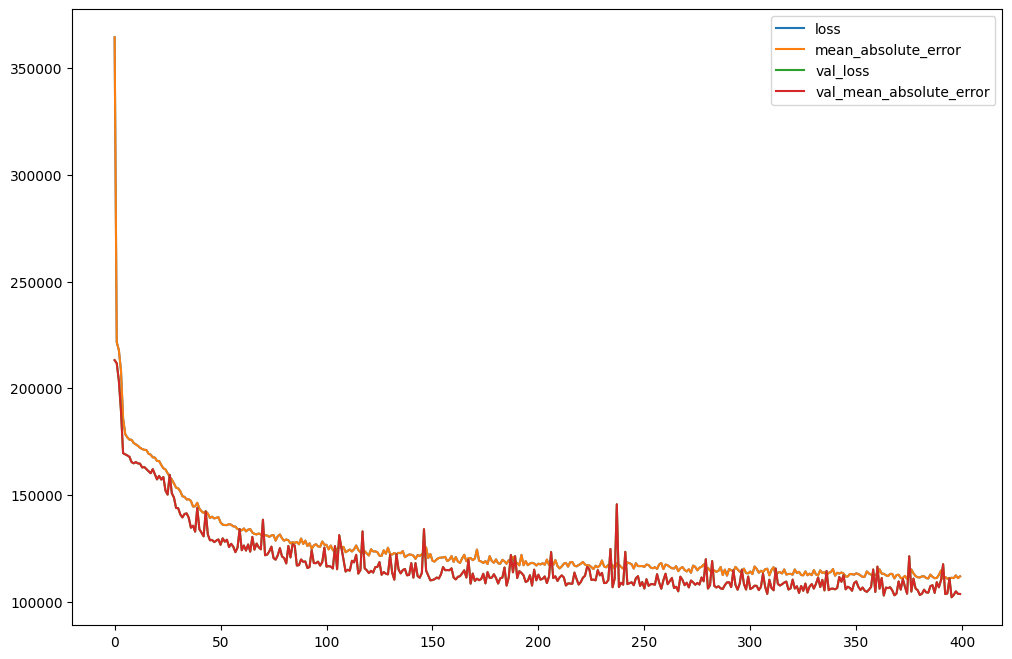

In [20]:
history_df.plot(figsize=(12,8))
